In [14]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
import os
from skimage.transform import resize
from random import shuffle
import pandas as pd
import cv2

data_dir = './data'

In [15]:
import pickle

# TODO: Fill this in based on where you saved the training and testing data
traffic_signs_data_dir = "%s/traffic-signs-data" % data_dir
training_file =  '%s/train.p' % traffic_signs_data_dir
validation_file = '%s/valid.p' % traffic_signs_data_dir
testing_file = '%s/test.p' % traffic_signs_data_dir
    
# Load pickled data
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [23]:
signnames_pd = pd.read_csv('signnames.csv')
signnames_pd

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


In [85]:
def signname_val_to_name(signnames_pd, val):
    #print("###", val)
    return signnames_pd[signnames_pd['ClassId'] == val]['SignName'].values[0]

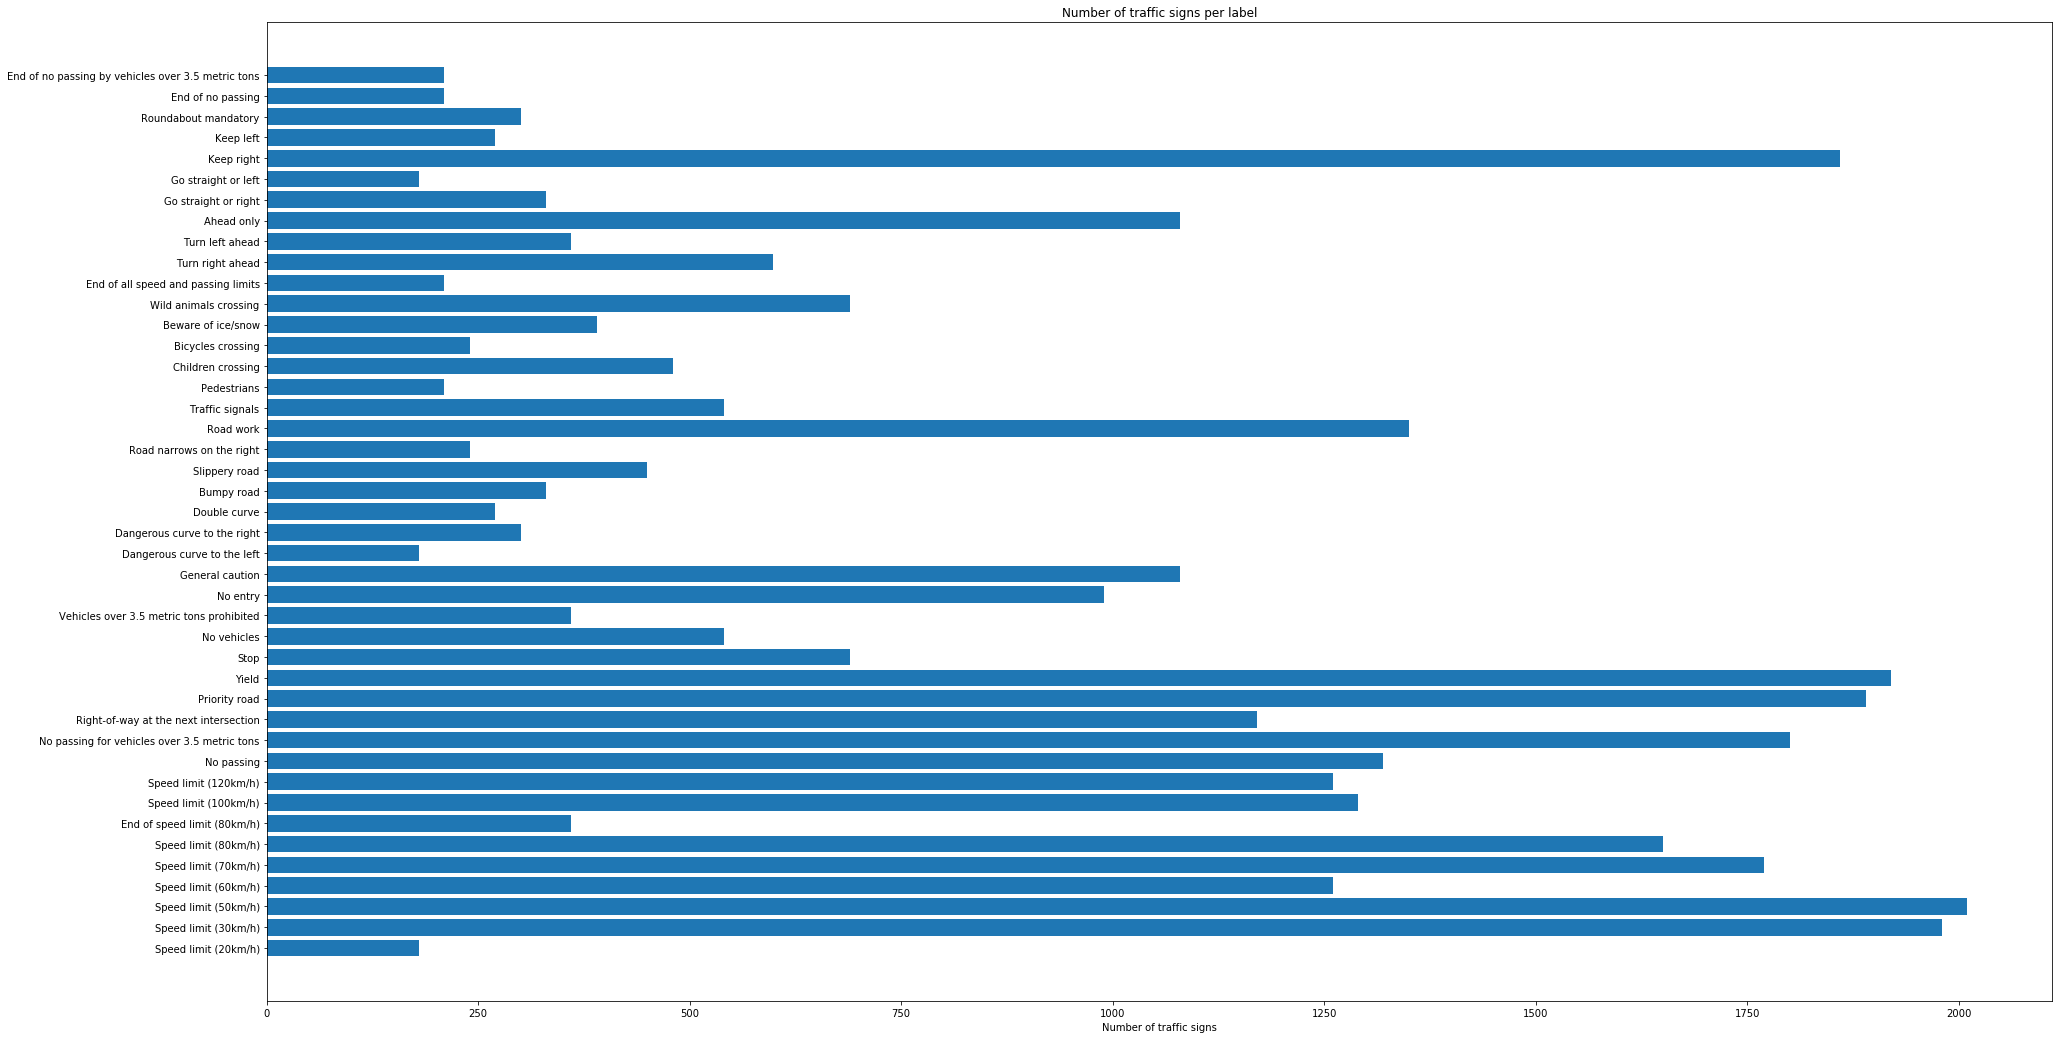

In [88]:
label_cnts = Counter(y_train)

x_vals = [x for x, _ in label_cnts.items()]
y_vals = [y for _, y in label_cnts.items()]    

plt.figure(figsize=(32,18))

plt.barh(x_vals, y_vals)
plt.title("Number of traffic signs per label")
plt.yticks(x_vals, [signname_val_to_name(signnames_pd, val) for val in x_vals])
plt.xlabel('Number of traffic signs')
#plt.ylabel('Label')
plt.show()

In [16]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

In [17]:
mu = 0
sigma = 0.1
alpha=0.05

x = tf.placeholder(tf.float32, (None, 32, 32, 5))

In [18]:
# Layer 1: Convolutional. Input = 32x32x4. Output = 32x32x32.
conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 5, 32), mean = mu, stddev = sigma))
conv1_b = tf.Variable(tf.zeros(32))
conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='SAME', 
                       name='conv1') + conv1_b
print(conv1.get_shape())

# Leaky ReLU
conv1 = tf.maximum(alpha * conv1, conv1)    

# Pooling. Input = 32x32x32. Output = 16x16x32.
conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
print(conv1.get_shape())

(?, 32, 32, 32)
(?, 16, 16, 32)


In [19]:
###
# Layer 2: Convolutional. Output = 16x16x64.
conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 32, 64), mean = mu, stddev = sigma))
conv2_b = tf.Variable(tf.zeros(64))
conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='SAME', 
                       name='conv2') + conv2_b
print(conv2.get_shape())

# Leaky ReLU
conv2 = tf.maximum(alpha * conv2, conv2)

# Pooling. Input = 16x16x64. Output = 8x8x64.
conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
###
print(conv2.get_shape())

(?, 16, 16, 64)
(?, 8, 8, 64)


In [20]:
###
# Layer 3: Convolutional. Output = 8x8x64.
conv3_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 64, 128), mean = mu, stddev = sigma))
conv3_b = tf.Variable(tf.zeros(128))
conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='SAME', name='conv3') + conv3_b
print(conv3.get_shape())

# Leaky ReLU
conv3 = tf.maximum(alpha * conv3, conv3)

# Pooling. Input = 8x8x128. Output = 4x4x128.
conv3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
###  
print(conv3.get_shape())

(?, 8, 8, 128)
(?, 4, 4, 128)


In [21]:
def apply_histogram_equalization(image):
    yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV).astype(np.uint8)
    yuv[:,:,0] = cv2.equalizeHist(yuv[:,:,0])
    
    return cv2.cvtColor(yuv, cv2.COLOR_YUV2RGB).astype(np.uint8)

In [22]:
def display_X_y_images(X, y, signnames_pd, start_idx=0, end_idx=None, columns = 5):
    if end_idx is None:
        end_idx = X.shape[0]
        
    plt.figure(figsize=(32,18))

    num_of_images = end_idx - start_idx
    for i in range(start_idx, end_idx):
        image = X[i]
        
        _i = i % num_of_images
        plt.subplot(num_of_images / columns + 1, columns, _i + 1)
        
        if y[i] == -1:
            title = 'Unlabeled'
        else:
            title = signnames_pd.loc[signnames_pd['ClassId']==y[i]]['SignName'].values[0]
            
        plt.title(title)
        plt.imshow(image)

In [24]:
idxs = [x for x in range(X_train.shape[0])]
shuffle(idxs)
X_train = X_train[idxs]
y_train = y_train[idxs]

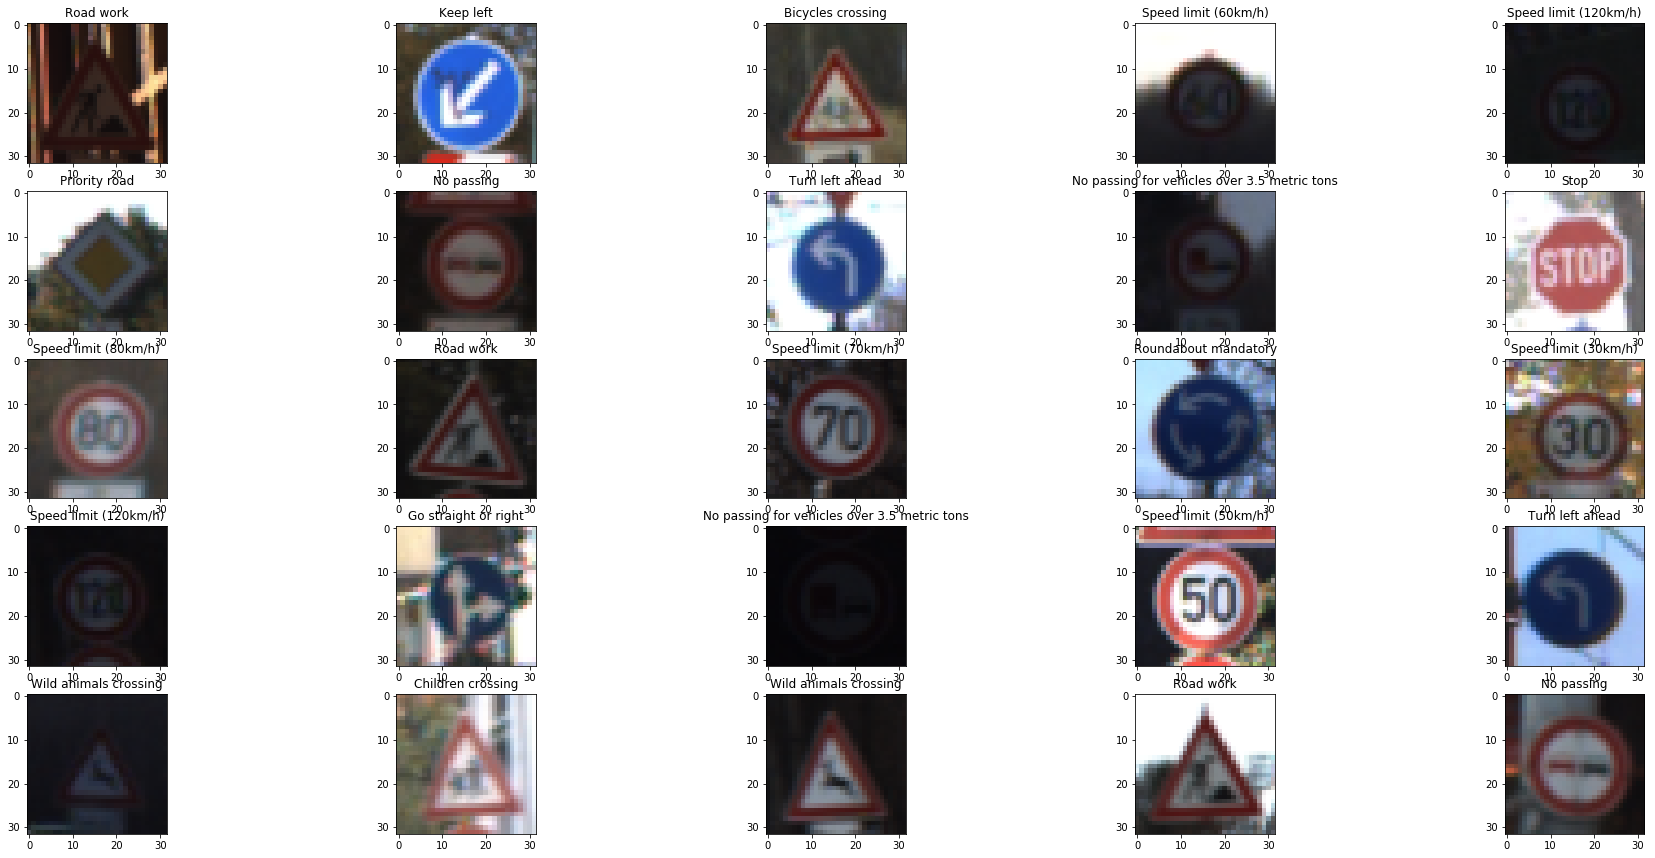

In [25]:
display_X_y_images(X_train, y_train, signnames_pd, 0, 25)

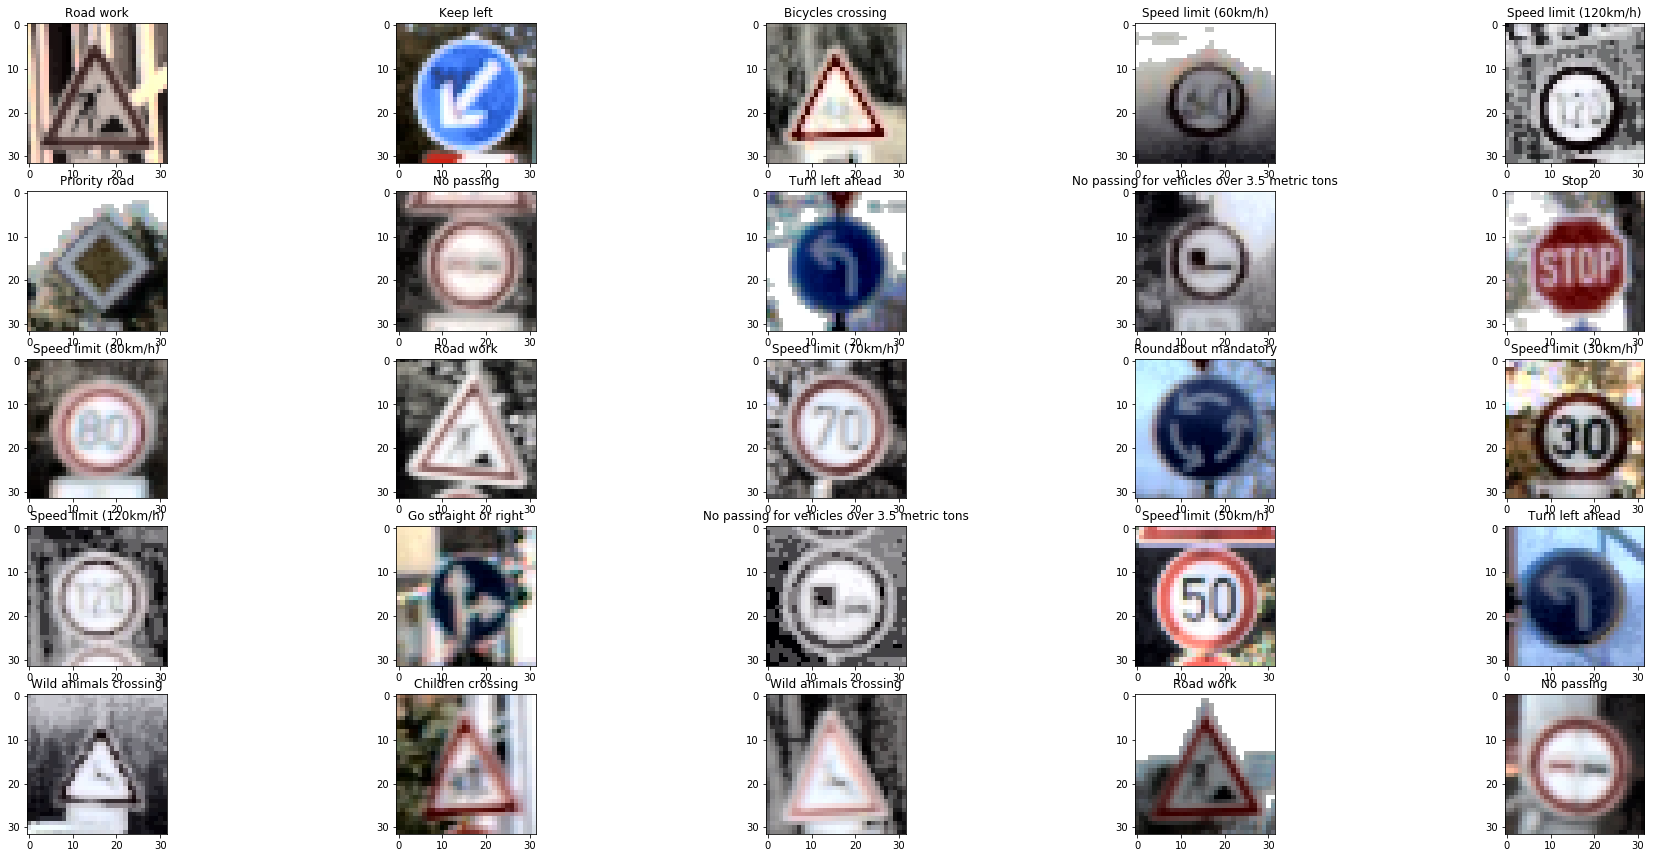

In [26]:
display_X_y_images(np.stack([apply_histogram_equalization(X_train[i]) for i in range(25)]), y_train, signnames_pd, 0, 25)

In [48]:
from collections import Counter

In [62]:
from skimage.transform import rotate, AffineTransform, warp
from random import uniform, randrange
import cv2

def apply_random_rotate(image, min_angle, max_angle):
    random_angle = uniform(min_angle, max_angle)
    
    return (255.0*rotate(image, random_angle)).astype(np.uint8)

def apply_random_shift(image, min_x_shift=-3, max_x_shift=3, min_y_shift=-3, max_y_shift=3):
    x_shift = randrange(min_x_shift, max_x_shift)
    y_shift = randrange(min_y_shift, max_y_shift)
    
    cols,rows = image.shape[0], image.shape[1]
    
    M = np.float32([[1,0,x_shift],[0,1,y_shift]])
    return cv2.warpAffine(image,M,(cols,rows))

def apply_random_shear(image, min_shear=-0.3, max_shear=0.3):
    shear = uniform(min_shear, max_shear)
    
    # Create Afine transform
    afine_tf = AffineTransform(shear=shear)

    # Apply transform to image data
    return warp(image, inverse_map=afine_tf)

def add_gaussian_noise(image, noise_sigma):
    temp_image = image.copy().astype(np.float32)
    
    h = temp_image.shape[0]
    w = temp_image.shape[1]
    noise = np.random.randn(h, w) * noise_sigma
    
    noisy_image = np.zeros(temp_image.shape)
    
    noisy_image[:,:,0] = temp_image[:,:,0] + noise
    noisy_image[:,:,1] = temp_image[:,:,1] + noise
    noisy_image[:,:,2] = temp_image[:,:,2] + noise    
    
    noisy_image[noisy_image < 0.0] = 0.0
    noisy_image[noisy_image > 255.0] = 255.0
    
    return noisy_image.astype(np.uint8)

def apply_random_light(image, min_perc, max_perc):
    light_perc = uniform(min_perc, max_perc)
    
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv[:, :, 2] = hsv[:, :, 2] * light_perc
    
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

def balance_images(X, y, min_angle=-12.5, max_angle=12.5, 
                   min_x_shift=-3, max_x_shift=3, min_y_shift=-5, max_y_shift=5, 
                   min_shear=-0.2, max_shear=0.2):
    label_cnts = Counter(y_train)
    
    max_cnt = max([y for _, y in label_cnts.items()])
    
    image_dict = {}
    for i in range(X.shape[0]):
        curr_image = X[i]
        curr_y = y[i]
        
        if curr_y in image_dict:
            image_dict[curr_y].append(curr_image)
        else:
            image_dict[curr_y] = [curr_image]
            
    for label, image_arr in image_dict.items():
        initial_cnt = len(image_arr)
        for i in range(max_cnt-initial_cnt):
            idx = randrange(0, initial_cnt)
            curr_image = image_arr[idx]
                
            rnd = randrange(0,3)    
            if rnd == 0:
                alt_image = apply_random_rotate(curr_image, min_angle, max_angle)  
            elif rnd == 1:
                apply_random_shift(image, min_x_shift, max_x_shift, 
                                   min_y_shift, max_y_shift)                 
            else:
                alt_image = apply_random_shear(image, min_shear, max_shear)
                
            image_dict[label].append(alt_image)
            
    balanced_label_arr = []
    balanced_image_arr = []
    for label, image_arr in image_dict.items():
        balanced_label_arr += [label] * len(image_arr)
        balanced_image_arr += image_arr
        
    balanced_labels = np.array(balanced_label_arr).reshape((-1))
    balanced_images = np.stack(balanced_image_arr)
    
    return balanced_images, balanced_labels

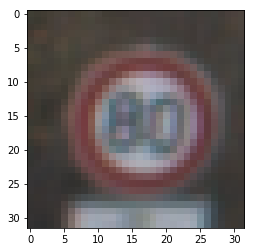

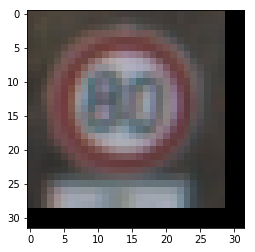

In [78]:
image = X_train[10]
shifted_image = apply_random_shift(image)
plt.imshow(image)
plt.show()
plt.imshow(shifted_image)
plt.show()

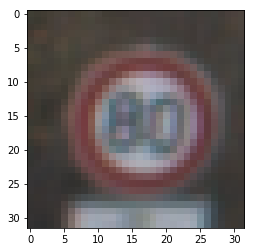

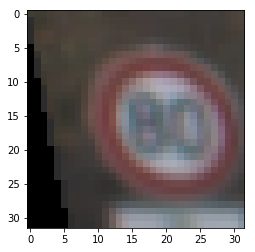

In [73]:
image = X_train[10]
sheared_image = apply_random_shear(image)
plt.imshow(image)
plt.show()
plt.imshow(sheared_image)
plt.show()

In [65]:
X_train_balanced, y_train_balanced = balance_images(X_train, y_train)
idxs = [x for x in range(X_train_balanced.shape[0])]
shuffle(idxs)
X_train_balanced = X_train_balanced[idxs]
y_train_balanced = y_train_balanced[idxs]

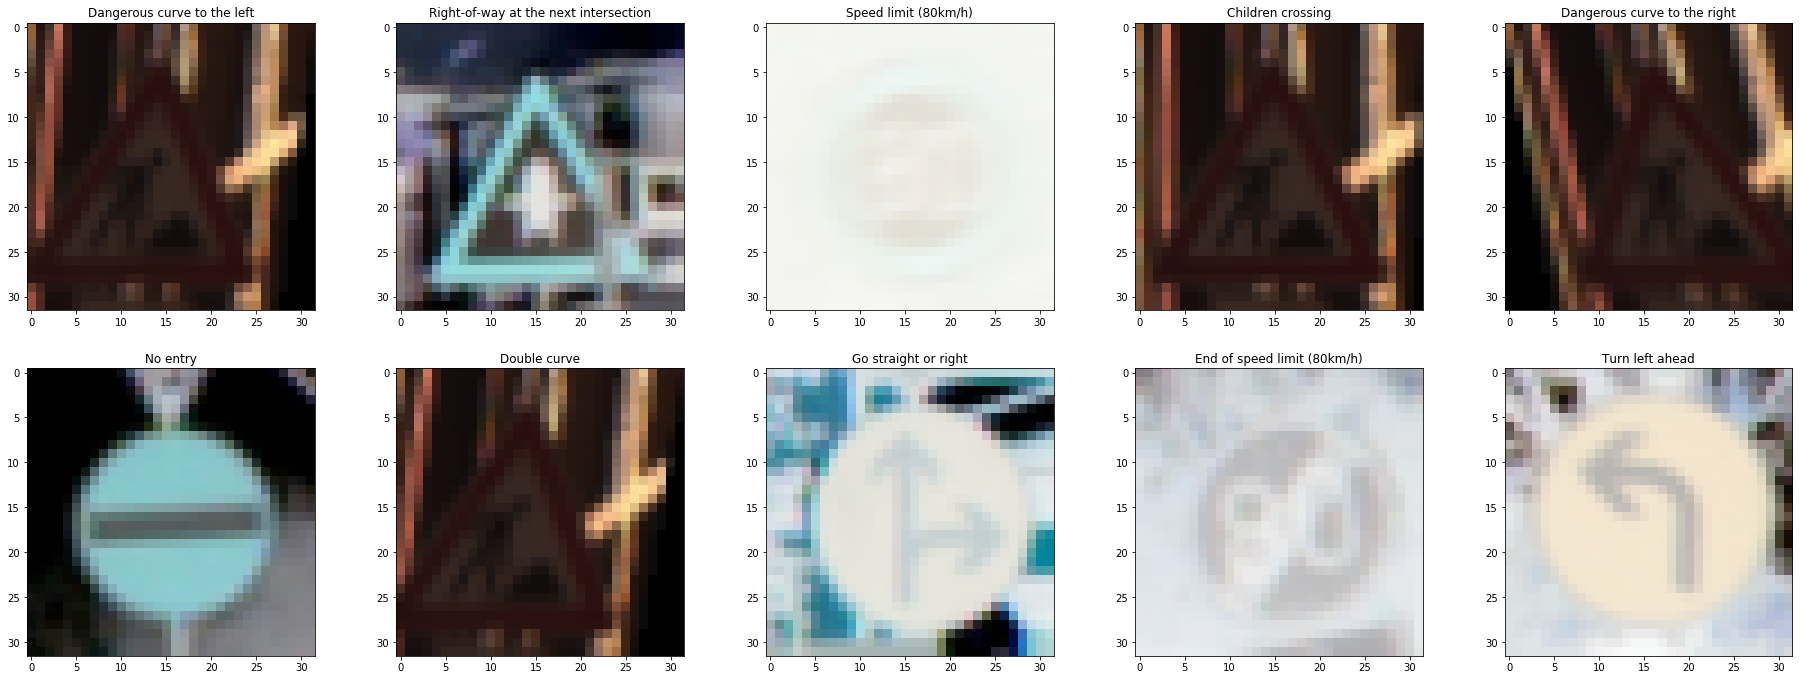

In [66]:
display_X_y_images(X_train_balanced, y_train_balanced, signnames_pd, 20, 30)